In [45]:
!pip install ffmpeg-python
!pip install sounddevice

import matplotlib.pyplot as plt
from IPython.display import HTML, Audio
from base64 import b64decode
import numpy as np
import statistics

import json
import time

import struct
import io
import ffmpeg
import sounddevice as sd

from scipy.io import wavfile
from scipy.io.wavfile import read as wav_read
from scipy import signal, stats
from scipy.signal import chirp, detrend, detrend, butter, filtfilt, find_peaks, savgol_filter

In [46]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutoff / nyq
    b, a = signal.butter(order, normalCutoff, btype='low')
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def highpass(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='high')
    return filtfilt(b, a, data)

# HR range (0.67–3.33 Hz = 40–200 BPM)
def bandpass(data, lowcut, highcut, fs, order=10):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [47]:
def play_and_record_chirp(freq_low,freq_high,sample_rate,chirp_duration,total_duration,sd):

    sd.default.channels   = 1
    sd.default.samplerate = sample_rate

    chirp_t               = np.linspace(0, chirp_duration, int(sample_rate*chirp_duration))
    chirp_x               = chirp(chirp_t,f0=freq_low,f1=freq_high,t1=chirp_duration,method='linear').astype(np.float32)
    chirps_needed         = int(total_duration / chirp_duration)
    tx                    = np.tile(chirp_x, chirps_needed)
    rx                    = sd.playrec(tx)

    return tx,rx

In [51]:
sample_rate = 48000
freq_low = 1000        # start of chirp (Hz)
freq_high = 23000       # end of chirp (Hz)
chirp_length = 0.1      # duration of each chirp in seconds
total_duration = 60     # total recording time in seconds

c = 343  # (m/s)
bandwidth = freq_high-freq_low  

range_resolution = c / (2 * bandwidth)
print(f"resolution: {range_resolution * 1000:.1f} mm")

resolution: 7.8 mm


In [259]:
tx,rx = play_and_record_chirp(freq_low,freq_high,sample_rate,chirp_length,total_duration,sd)

In [261]:
tx_sig = tx;
rx_sig = rx[:,0]

num_chirps_recorded = int(rx_sig.shape[0] // (chirp_length * sample_rate))

# trim audio to a whole number of chirps recorded
rx_sig = rx_sig[:int(num_chirps_recorded * chirp_length * sample_rate)]

rx_data = np.array(np.split(rx_sig, num_chirps_recorded))
tx_data = np.tile(tx_sig[0:int(chirp_length*sample_rate)], (num_chirps_recorded, 1))

time_to_drop = 1
segments_to_drop = int(time_to_drop/chirp_length)
rx_data = rx_data[segments_to_drop:]
tx_data = tx_data[segments_to_drop:]

window_length = rx_data.shape[1]
print(window_length)

sample_index = 0

### save to json for testing ###
rx_list = rx_data.tolist()
tx_list = tx_data.tolist()

with open("rx_hrbr.json", "w") as f:
    json.dump(rx_list, f)

with open("tx_hrbr.json", "w") as f:
    json.dump(tx_list, f)
### save to json for testing ###

4800


In [262]:
def background_subtract(all_multiplied_ffts):
    after_subtraction = []
    for i in range(30, len(all_multiplied_ffts)):
        after_subtraction.append(all_multiplied_ffts[i] - all_multiplied_ffts[i-30])
    return np.array(after_subtraction)

def moving_average(x, w):
    return np.convolve(x, np.ones(w)/w, mode='same')

def get_largest_n_mean(array, n):
    return np.mean(np.argpartition(array, -n)[-n:])

In [263]:
# --- Load Data ---
with open("tx_hrbr.json", "r") as f_tx, open("rx_hrbr.json", "r") as f_rx:
    tx_data = json.load(f_tx)
    rx_data = json.load(f_rx)

tx_data = np.array(tx_data)
rx_data = np.array(rx_data)

window_length = rx_data.shape[1]
chirp_length = 0.1 

In [264]:
# --- FMCW ---
dechirped = rx_data * np.conj(tx_data)
fft_data = np.fft.fft(dechirped, n=fft_size, axis=1)

fft_size = window_length*4
fft_data = np.fft.fft(dechirped, n=fft_size, axis=1)

subtracted = background_subtract(np.fft.fftshift(fft_data, axes=(1,))) # remove signal from stationary objects
all_peak_locations = np.apply_along_axis(np.argmax, 1, np.fft.fftshift(fft_data, axes=(1,))) # for every chirp, find max fft
median_peak_location = int(np.median(all_peak_locations)) # find median bin

# define window around median peak
peak_window_size     = 100
window_range_start   = median_peak_location - peak_window_size/2
window_range         = np.arange(window_range_start,
                         window_range_start + peak_window_size,
                         dtype=np.int32)

freqs               = np.multiply(np.fft.rfftfreq(window_length), sample_rate) # calculate freq bins
subtracted_filtered = subtracted[:, window_range] # extract windowed region
argmaxes = np.apply_along_axis(np.argmax, 1, subtracted_filtered) # find peak location for each chirp
MOVING_AVERAGE_LENGTH = 5
MEDIAN_FILTER_LENGTH  = 7
med_filtered = signal.medfilt(argmaxes, MEDIAN_FILTER_LENGTH) # smooth peak locations

# bin_to_track = np.argmax(np.mean(np.abs(fft_data), axis=0))
bin_to_track = int(np.median(med_filtered))
phases = np.angle(fft_data[:, bin_to_track])

unwrapped_phases = np.unwrap(phases)
detrended_phase = detrend(unwrapped_phases)

times = np.arange(unwrapped_phases.shape[0]) * chirp_length

fs = 1 / chirp_length
hr_filtered = bandpass(detrended_phase, 45 / 60, 200 / 60, fs)

In [265]:
# --- FFT Method ---
hr_fft = np.fft.rfft(hr_filtered)
hr_freqs = np.fft.rfftfreq(len(hr_filtered), d=chirp_length)
hr_bpm_freqs = hr_freqs * 60
mask = (hr_bpm_freqs >= 40) & (hr_bpm_freqs <= 200)
hr_bpm_freqs = hr_bpm_freqs[mask]
hr_fft_mag = np.abs(hr_fft)[mask]

if len(hr_fft_mag) > 5:
    min_bpm = 40  # min expected heart rate
    min_idx = np.argmin(np.abs(hr_bpm_freqs - min_bpm))
    peak_idx = np.argmax(hr_fft_mag[min_idx:]) + min_idx
else:
    peak_idx = np.argmax(hr_fft_mag)

bpm_from_fft = hr_bpm_freqs[peak_idx]

In [266]:
# --- Peak Detection Method ---
smoothed = moving_average(hr_filtered, w=5)

peaks, _ = find_peaks(smoothed, height=0.0001, distance=fs/8)

if len(peaks) > 1:
    intervals = np.diff(times[peaks])
    avg_interval = np.mean(intervals)
    med = statistics.median(intervals)
    bpm_from_peaks = 60 / med
else:
    bpm_from_peaks = None

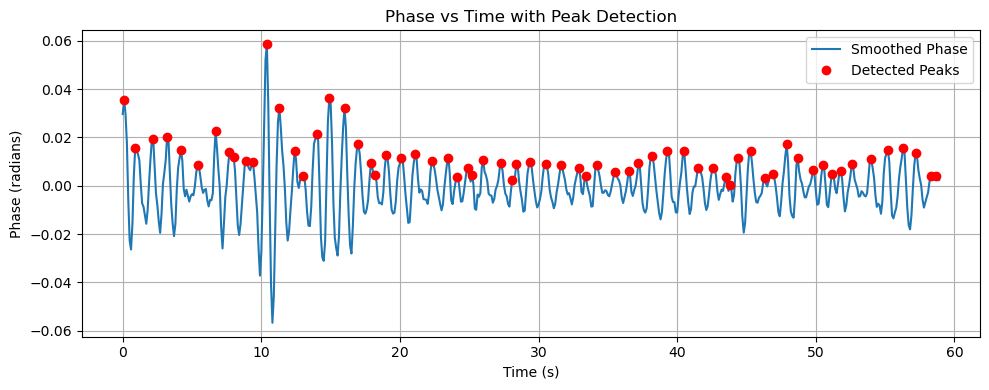

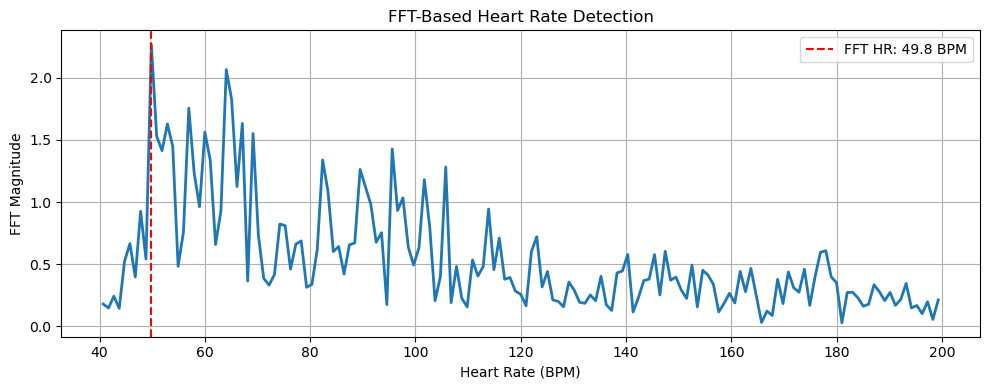

Heart Rate (from peak intervals): 60.00 BPM
Heart Rate (from FFT): 49.83 BPM


In [267]:
# --- Plot Phase vs Time and Peaks ---
plt.figure(figsize=(10, 4))
plt.plot(times, smoothed, label='Smoothed Phase')
plt.plot(times[peaks], smoothed[peaks], 'ro', label='Detected Peaks')
plt.xlabel("Time (s)")
plt.ylabel("Phase (radians)")
plt.title("Phase vs Time with Peak Detection")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot FFT ---
plt.figure(figsize=(10, 4))
plt.plot(hr_bpm_freqs, hr_fft_mag, linewidth=2)
plt.axvline(x=bpm_from_fft, color='r', linestyle='--', label=f'FFT HR: {bpm_from_fft:.1f} BPM')
plt.xlabel("Heart Rate (BPM)")
plt.ylabel("FFT Magnitude")
plt.title("FFT-Based Heart Rate Detection")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Print results ---
if bpm_from_peaks:
    print(f"Heart Rate (from peak intervals): {bpm_from_peaks:.2f} BPM")
else:
    print("Not enough peaks for interval-based heart rate.")

print(f"Heart Rate (from FFT): {bpm_from_fft:.2f} BPM")
